<IPython.core.display.Javascript object>


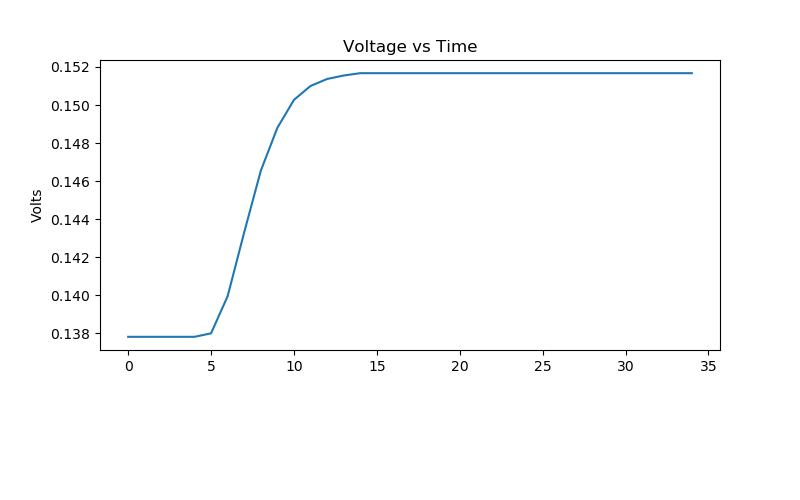

saved LaserV_2021_02_10_14.59.50.csv


In [71]:
# Necessary for showing plot on Jupyter notebook
%matplotlib notebook

# Imports for instrument (SRS810) control
import pyvisa as visa
import numpy as np

# Imports for plotting
from matplotlib import pyplot as plt 
import matplotlib.animation as animation
import time
import datetime as dt

# Imports for File I/O
import csv
import os

# SRS810 code pulled from QNLgit/probestation. Contains methods for reading and writing to device
class SR810_lockin():
    def __init__(self,gpib_addr='GPIB0::8::INSTR'):
        self.gpib_addr = gpib_addr
        self.dev = visa.ResourceManager().open_resource(gpib_addr)
        self.dev.write('OUTX 1') # Use GPIB
        self.dev.write('OVRM 1') # Don't lock out the front panel

    def reconnect(self):
        """Reinstantiate the device."""
        self.dev = visa.ResourceManager().open_resource(self.gpib_addr)

    def voltage_out(self, voltage=None):
        """Get/Set the excitation voltage of the lockin
        
        Args: 
            voltage: Voltage in volts. `None` to query.
        
        Returns: 
            voltage in volts.
        """
        if voltage is not None:
            self.dev.write('SLVL {}'.format(voltage))
        return float(self.dev.query('SLVL?'))

    def voltage_in(self):
        """Get the probe voltage of the lockin.
        
        Returns: 
            Voltage in volts. will return `-1` on overload.
        """

        # verify not over voltage
        self.dev.write('*CLS')
        status_byte = int(self.dev.query('LIAS?'))
        over_voltage = (status_byte & 4) >> 2
        if over_voltage:
            return(-1)

        return float(self.dev.query('OUTP? 3'))

    def sensitivity(self,sense=None):
        """Get/set the sensitivity of the lockin.
        
        Args:
            sense: Sense parameter. (0 through 26). `None` to query.
        
        Returns: 
            Sense parameter (0 through 26).
        Note:
            The sense parameters are given below. 
            | Sense | Setting       |
            |-------|---------------|
            | 0     | 2 nV/fA       |
            | 1     | 5 nV/fA       |
            | 2     | 10 nV/fA      |
            | 3     | 20 nV/fA      |
            | 4     | 50 nV/fA      |
            | 5     | 100 nV/fA     |
            | 6     | 200 nV/fA     |
            | 7     | 500 nV/fA     |
            | 8     | 1 µV/pA       |
            | 9     | 2 µV/pA       |
            | 10    | 5 µV/pA       |
            | 11    | 10 µV/pA      |
            | 12    | 20 µV/pA      |
            | 13    | 50 µV/pA      |
            | 14    | 100 µV/pA     |
            | 15    | 200 µV/pA     |
            | 16    | 500 µV/pA     |
            | 17    | 1 mV/nA       |
            | 18    | 2 mV/nA       |
            | 19    | 5 mV/nA       |
            | 20    | 10 mV/nA      |
            | 21    | 20 mV/nA      |
            | 22    | 50 mV/nA      |
            | 23    | 100 mV/nA     |
            | 24    | 200 mV/nA     |
            | 25    | 500 mV/nA     |
            | 26    | 1 V/µA        |
        """
        if sense is not None:
            assert sense >= 0 and sense <= 26, 'Sense "{}" is out of range'.format(sense)
            self.dev.write('SENS {}'.format(sense))
        return float(self.dev.query('SENS?'))

    def time_constant(self,tc=None):
        """Get/set the time constant.
        
        Args: 
            tc: Time constant (0 through 19). `None` to query.
        Returns: 
            Time constant (0 through 19).
        Note:
            The time constant parameters are given below.
            | TC    | Time      |
            |-------|-----------|
            | 0     | 10 µs     |
            | 1     | 30 µs     |
            | 2     | 100 µs    |
            | 3     | 300 µs    |
            | 4     | 1 ms      |
            | 5     | 3 ms      |
            | 6     | 10 ms     |
            | 7     | 30 ms     |
            | 8     | 100 ms    |
            | 9     | 300 ms    |
            | 10    | 1 s       |
            | 11    | 3 s       |
            | 12    | 10 s      |
            | 13    | 30 s      |
            | 14    | 100 s     |
            | 15    | 300 s     |
            | 16    | 1 ks      |
            | 17    | 3 ks      |
            | 18    | 10 ks     |
            | 19    | 30 ks     |
        """

        if tc is not None:
            assert tc >= 0 and tc <= 19, 'Sense "{}" is out of range'.format(tc)
            self.dev.write('OFLT {}'.format(tc))
        return float(self.dev.query('OFLT?'))

            
if __name__ == '__main__':
    # data arrays
    T = []
    data = []
    
    # Instrument initialization
    inst = SR810_lockin('GPIB0::8::INSTR')
    
    # Plotting initialization
    fig = plt.figure(figsize=(8,5), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    try:
        while True: # Continuously taking data; click 'stop kernel' to quit data taking
            T.append(dt.datetime.now().strftime('%H:%M:%S'))
            Volt = inst.voltage_in()
            data.append(Volt)
            
            ax.clear()
            plt.xticks(rotation=45, ha='right')
            plt.subplots_adjust(bottom=0.30)
            plt.title('Voltage vs Time')
            plt.ylabel('Volts')
            if len(T)>20:
                ax.plot(T[len(T)-20:len(T)], data[len(data)-20:len(data)]) # Shows recent 20 data points to not cram x-axis
            else:
                ax.plot(T,data)
            fig.canvas.draw()
            time.sleep(1) # Places around 1 second interval between data collection
            continue
        
    except KeyboardInterrupt: # data saving procedures 
        current_date = dt.datetime.now().strftime('%Y_%m_%d') # Saves foldername with current date
        current_date_and_time = dt.datetime.now().strftime('%Y_%m_%d_%H.%M.%S') # Saves filename with current date and time
        current_date_and_time_string = str(current_date_and_time)
        extension = ".csv"
        filename =  "LaserV_"+ current_date_and_time_string + extension
        foldername = "LaserV_" + current_date

        with open(filename, 'wb') as csvfile: # Saves data to csv file
            filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
            filewriter.writerow(T)
            filewriter.writerow(data)
        
        dir_path = os.path.dirname(os.path.realpath(filename)) # Creates folder with foldername and moves file to this folder
        newdir = os.path.join(dir_path, foldername)
        if not os.path.exists(newdir):
            os.makedirs(newdir)
        oldpath = os.path.join(dir_path, filename)
        newpath = os.path.join(newdir, filename)
        os.rename(oldpath, newpath)
            
        print("saved " + filename) # To indicate successful completion of script
        
        ax.clear() # Plot final result. 
        plt.plot(list(range(0,len(T))),data) # X-axis tweaked so that it isn't clustered with timestamps
        plt.title('Voltage vs Time')
        plt.ylabel('Volts')
        plt.show()
        
